# Analyzing S & P robot data

## Import libraries

In [1]:
import os, os.path

In [2]:
from skimage import io,util

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Convert pictures (crop, levels of gray,...)

In [4]:
def get_modified_image(image, outp, pic_fname, xoff=500, yoff=300):
    # xoff are yoff the number of pixels that will be cropped from the picture
    
    #Output folder is created only if it doesn't already exist
    from pathlib import Path
    Path(outp).mkdir(parents=True, exist_ok=True)
    
    #Picture is cropped. I've added +80 because the plate is not perfectly centered, which means there's more to crop on the left than on the right
    y1,y2,x1,x2=yoff,image.shape[0]-yoff,xoff,image.shape[1]-xoff+80
    cropped = image[y1:y2,x1:x2]

    #Picture is converted into levels of gray
    from skimage.color import rgb2gray
    grayscale = rgb2gray(cropped)
    
    #Levels of gray are inverted: gray on white background equals growth
    grayscale=util.invert(grayscale)
    
    out=util.img_as_ubyte(grayscale)

    #Converted picture is saved
    io.imsave(outp+pic_fname, out)
    return out, outp+pic_fname

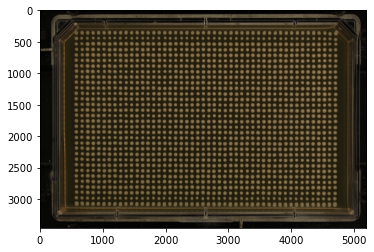

In [5]:
p = './images/Dox_3_20221018/'
outp = p[:-1]+'_edit/'
pic_fname = 'd000266_300_010_22-10-15_23-10-04.JPG'

#Visualization of original picture
image = io.imread(p+pic_fname)
imgplot = plt.imshow(image)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

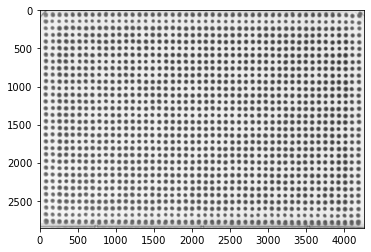

In [6]:
image = io.imread(p+pic_fname)

#Visualization of modified picture
modif = get_modified_image(image, outp, pic_fname)

#By using the function below, one can retrieve either the object, or re-load the picture from the file
imgplot = plt.imshow(modif[0], cmap='binary_r')
#image = io.imread(modif[1])
#imgplot = plt.imshow(image, cmap='binary_r')

plt.show

## Batch conversion of all pictures

In [7]:
for f in os.listdir(p):
    fname = os.path.basename(f)
    image = io.imread(p+fname)
    #print(fname)
    get_modified_image(image, outp, pic_fname = fname)

## Check that all pictures have been converted

In [8]:
#Here we simply check that the number of pictures is the same in both folders
nb_p =len([name for name in os.listdir(p) if os.path.isfile(p+name)])
nb_outp =len([name for name in os.listdir(outp) if os.path.isfile(outp+name)])
if nb_p == nb_outp:
    print(nb_p, nb_outp, "All photos have been succesfully converted!")
else:
    print(nb_p, nb_outp, "Some photos have not been succesfully converted...")

598 598 All photos have been succesfully converted!


In [9]:
#one can compare the file names like this:
p_files = []
outp_files = []

for f in os.listdir(p):
    fname = os.path.basename(f)
    p_files.append(fname)

for f in os.listdir(outp):
    fname = os.path.basename(f)
    outp_files.append(fname)

#Note, the block below works only in one direction
for f in outp_files:
    if f not in p_files:
        print(f)

## Analyze spots with pyphe-quantify

In [4]:
# Pyphe should be installed in a virtual environment to prevent incompatibilities. Use pip install as described below, or conda install
# >conda create --name pyphe-venv python=3.7
# >pip install pyphe
# >chmod -R 777 /Users/danyamamotoevans/opt/anaconda3/bin/pyphe*
#
# To launch the virtual environment:
# >conda activate pyphe-venv
#
# Command line is typed from the folder *_edit
# >/Users/danyamamotoevans/opt/anaconda3/bin/pyphe-quantify batch --grid auto_1536 --pattern "*.JPG" --s 0.1
# Grid should be adapted based on the experiment, 384, 1536, etc.

## Analyze data generated by pyphe-quantify

In [10]:
outp = './images/Dox_3_20221018_edit/'

import glob
import math
from datetime import datetime
list_of_plate_df = []

for f in glob.glob(outp + 'pyphe_quant/*.csv'):  
    plate_df = pd.read_csv(f, header=0, index_col=0)

    #For every picture in the folder, the file name is read and parsed ('_') to retrieve the plate number and timestamp
    plate_df['plate_number']=f.split('.JPG.csv')[0].split("/")[-1]
    #print(plate_df['plate_number'])
        
    list_of_plate_df.append(plate_df)

#Above we created one dataframe per plate, which we now concatenate into a single dataframe
pic_df = pd.concat(list_of_plate_df, axis=0)

#This is useful if the plate has been expanded to feature 4 replicates per samples
#'spot_well' would designate a single spot (= one replicate)
#'RA_well' is short for 'rearray_well' and designates a sample on the original plate (before expansion)
#For example B1 if I'm not mistaken, corresponds to the third replicate on a 384-array of sample in A1 on the corresponding 96-array pre-expansion
pic_df['spot_well'] = pic_df.apply(lambda row: chr(64 + row.row) + str(row.column), axis=1)
pic_df['RA_well'] = pic_df.apply(lambda row: chr(64 + math.ceil(row.row / 2)) + str(math.ceil(row.column / 2)), axis=1)

pic_df

,area,centroid,mean_intensity,perimeter,row,column,circularity,plate_number,spot_well,RA_well
1,3034,"(53.71588661832564, 865.0886618325643)",0.350755,213.923882,1,10,0.833119,d000265_300_023_22-10-14_09-20-07,A10,A5
2,2952,"(56.1029810298103, 2526.997628726287)",0.359015,208.610173,1,29,0.852423,d000265_300_023_22-10-14_09-20-07,A29,A15
3,2688,"(54.976190476190474, 691.5770089285714)",0.350023,196.024387,1,8,0.879061,d000265_300_023_22-10-14_09-20-07,A8,A4
4,2838,"(56.22128259337562, 1040.4506694855531)",0.349869,201.681241,1,12,0.876781,d000265_300_023_22-10-14_09-20-07,A12,A6
5,2714,"(56.750184229918936, 1564.3021370670597)",0.356734,200.509668,1,18,0.848299,d000265_300_023_22-10-14_09-20-07,A18,A9
...,...,...,...,...,...,...,...,...,...,...
1531,3279,"(2786.3738944800243, 3743.650503202196)",0.366011,224.651804,32,43,0.816454,d000265_300_015_22-10-14_09-14-33,`43,P22
1532,3764,"(2786.1742826780023, 4090.1780021253985)",0.352688,236.793939,32,47,0.843565,d000265_300_015_22-10-14_09-14-33,`47,P24
1533,3280,"(2785.4408536585365, 3831.244817073171)",0.364222,215.580736,32,44,0.886878,d000265_300_015_22-10-14_09-14-33,`44,P22
1534,3604,"(2787.927857935627, 3916.7816315205328)",0.364734,225.338095,32,45,0.891919,d000265_300_015_22-10-14_09-14-33,`45,P23


In [11]:
pic_df.to_csv('dox_selection_3_20221019_pyphe_output.csv')